# Capstone Project - The Battle of Neighborhoods (Final Week) 
<h2>Best Neighborhood for retirement in South Florida</h2>
Uses Cities Data, Crime Data from FBI, and Foursquare API to explore neighborhoods, and K-Mean Clustering to Analyze neighbourhood clusters


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  Download South Florida Cites-information 

2.  Filter Cities based on Criteria - Crime Rate, Beach Cities

3.  Analyze Neighborhood for Top Cities

4.  Cluster Neighborhoods

5.  Examine Clusters 
    </font>
    </div>


#### Import Required Python Packages
Note: Warning is set to ignore

In [1]:
import pandas as pd
import requests
import numpy as np

import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

<h3> Load All the required data:</h3>
    1. All the Florida cities
    2. Crime Rate for all the Florida Cities
    3. All the Florida beach cities
    4. Neighbourhoods for the finally selected cities

#### Load all the Florida Cities by counties 

In [2]:
url='https://dos.myflorida.com/library-archives/research/florida-information/government/local-resources/citycounty-list/counties/'
dfflcities=pd.read_html(url, header=0)[0]
dfflcities.columns = ['county','city','citytype'] 
dfflcities.head()

,county,city,citytype
0,Alachua,Alachua,city
1,Alachua,Archer,city
2,Alachua,Cross Creek,populated place
3,Alachua,Earleton,populated place
4,Alachua,Gainesville,city


### Since we are interested in South Florida, filter cities for six South Florida Counties

In [4]:
df_sfcities = dfflcities[((dfflcities['county']=='Broward') | (dfflcities['county']=='Collier') | (dfflcities['county']=='Palm Beach') | (dfflcities['county']=='Lee') | (dfflcities['county']=='Miami-Dade') | (dfflcities['county']=='Monroe')) & (dfflcities['citytype']=='city')     ]
df_sfcities.reset_index(drop=True, inplace=True)
df_sfcities['address']=df_sfcities['city']+', Florida'
df_sfcities.head(10)

,county,city,citytype,address
0,Broward,Coconut Creek,city,"Coconut Creek, Florida"
1,Broward,Cooper City,city,"Cooper City, Florida"
2,Broward,Coral Springs,city,"Coral Springs, Florida"
3,Broward,Dania Beach,city,"Dania Beach, Florida"
4,Broward,Deerfield Beach,city,"Deerfield Beach, Florida"
5,Broward,Fort Lauderdale,city,"Fort Lauderdale, Florida"
6,Broward,Hallandale Beach,city,"Hallandale Beach, Florida"
7,Broward,Hollywood,city,"Hollywood, Florida"
8,Broward,Lauderdale Lakes,city,"Lauderdale Lakes, Florida"
9,Broward,Lauderhill,city,"Lauderhill, Florida"


### We will use Geopandas and geopy for finding geolocations for cities/neighbourhoods -  The Geopy geocoder documentation can be found in the following link: https://geopy.readthedocs.io/en/stable/

In [5]:
!pip install geopandas
!pip install geopy

     |████████████████████████████████| 962 kB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 21.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 33.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 22.3 MB/s eta 0:00:01


In [6]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent="myGeocoder") 
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
df_sfcities['location'] = df_sfcities['address'].apply(geocode) 
df_sfcities['point'] = df_sfcities['location'].apply(lambda loc: tuple(loc.point) if loc else None)  
df_sfcities[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_sfcities['point'].tolist(), index=df_sfcities.index)
df_sfcities.head()

,county,city,citytype,address,location,point,latitude,longitude,altitude
0,Broward,Coconut Creek,city,"Coconut Creek, Florida","(Coconut Creek, Broward County, Florida, Unite...","(26.2517482, -80.1789351, 0.0)",26.251748,-80.178935,0.0
1,Broward,Cooper City,city,"Cooper City, Florida","(Cooper City, Broward County, Florida, 33314:3...","(26.057783, -80.2695109, 0.0)",26.057783,-80.269511,0.0
2,Broward,Coral Springs,city,"Coral Springs, Florida","(Coral Springs, Broward County, Florida, Unite...","(26.271192, -80.2706044, 0.0)",26.271192,-80.270604,0.0
3,Broward,Dania Beach,city,"Dania Beach, Florida","(Dania Beach, Broward County, Florida, 33004, ...","(26.0524224, -80.143929, 0.0)",26.052422,-80.143929,0.0
4,Broward,Deerfield Beach,city,"Deerfield Beach, Florida","(Deerfield Beach, Broward County, Florida, Uni...","(26.318342, -80.0996306, 0.0)",26.318342,-80.099631,0.0


In [6]:
#save the csv for future.
df_sfcities.to_csv('df_sfcities.csv')

### Load Crime Data for all Florida Cities

In [12]:


flcrimeurl='https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-8/table-8-state-pieces/table_8_offenses_known_to_law_enforcement_florida_by_city_2015.xls'
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r = requests.get(flcrimeurl, headers=header) 
flcrime = pd.read_html(r.text)
dfflcrime = flcrime[0].dropna(axis=0, thresh=4)
dfflcrime['crimeperk']=round(1000*dfflcrime['Violentcrime']/dfflcrime['Population'],0)
dfflcrime.head()  

,City,Population,Violentcrime,Murder andnonnegligentmanslaughter,Rape(reviseddefinition)1,Rape(legacydefinition)2,Robbery,Aggravatedassault,Propertycrime,Burglary,Larceny-theft,Motorvehicletheft,Arson,crimeperk
0,Alachua,9687,33,0,4,NaN,1,28,261,51,204,6,0,3.0
1,Altamonte Springs,42409,154,0,25,NaN,27,102,1545,249,1237,59,1,4.0
2,Apalachicola,2287,1,0,0,NaN,0,1,133,21,112,0,0,0.0
3,Apopka,48478,179,2,12,NaN,47,118,1574,318,1170,86,4,4.0
4,Arcadia,7741,63,0,5,NaN,8,50,198,85,100,13,0,8.0


In [13]:
# Calculate Crime per K and Load only City and Crime rate to a dataframe, will be used for filtering
df_flcrime = dfflcrime.filter(['City','crimeperk'], axis=1)
df_flcrime.columns = ['city','crimerate']
df_flcrime.head()

,city,crimerate
0,Alachua,3.0
1,Altamonte Springs,4.0
2,Apalachicola,0.0
3,Apopka,4.0
4,Arcadia,8.0


In [14]:
sfcities_df = pd.merge(df_sfcities, df_flcrime, on = 'city')
sfcities_df.head()

,county,city,citytype,address,location,point,latitude,longitude,altitude,crimerate
0,Broward,Coconut Creek,city,"Coconut Creek, Florida","(Coconut Creek, Broward County, Florida, Unite...","(26.2517482, -80.1789351, 0.0)",26.251748,-80.178935,0.0,1.0
1,Broward,Cooper City,city,"Cooper City, Florida","(Cooper City, Broward County, Florida, 33314:3...","(26.057783, -80.2695109, 0.0)",26.057783,-80.269511,0.0,1.0
2,Broward,Coral Springs,city,"Coral Springs, Florida","(Coral Springs, Broward County, Florida, Unite...","(26.271192, -80.2706044, 0.0)",26.271192,-80.270604,0.0,2.0
3,Broward,Deerfield Beach,city,"Deerfield Beach, Florida","(Deerfield Beach, Broward County, Florida, Uni...","(26.318342, -80.0996306, 0.0)",26.318342,-80.099631,0.0,4.0
4,Broward,Fort Lauderdale,city,"Fort Lauderdale, Florida","(Fort Lauderdale, Broward County, Florida, Uni...","(26.1223084, -80.1433786, 0.0)",26.122308,-80.143379,0.0,7.0


In [15]:
def label_crime (row):
    if row['crimerate'] <= 2 :
        return 'green'
    if row['crimerate'] <= 5 :
        return 'yellow'
    if row['crimerate'] <= 8 :
        return 'orange'   
    return 'red'

sfcities_df['crimelevel'] = sfcities_df.apply (lambda row: label_crime(row), axis=1)
sfcities_df.head()

,county,city,citytype,address,location,point,latitude,longitude,altitude,crimerate,crimelevel
0,Broward,Coconut Creek,city,"Coconut Creek, Florida","(Coconut Creek, Broward County, Florida, Unite...","(26.2517482, -80.1789351, 0.0)",26.251748,-80.178935,0.0,1.0,green
1,Broward,Cooper City,city,"Cooper City, Florida","(Cooper City, Broward County, Florida, 33314:3...","(26.057783, -80.2695109, 0.0)",26.057783,-80.269511,0.0,1.0,green
2,Broward,Coral Springs,city,"Coral Springs, Florida","(Coral Springs, Broward County, Florida, Unite...","(26.271192, -80.2706044, 0.0)",26.271192,-80.270604,0.0,2.0,green
3,Broward,Deerfield Beach,city,"Deerfield Beach, Florida","(Deerfield Beach, Broward County, Florida, Uni...","(26.318342, -80.0996306, 0.0)",26.318342,-80.099631,0.0,4.0,yellow
4,Broward,Fort Lauderdale,city,"Fort Lauderdale, Florida","(Fort Lauderdale, Broward County, Florida, Uni...","(26.1223084, -80.1433786, 0.0)",26.122308,-80.143379,0.0,7.0,orange


In [16]:
urlbeaches = 'https://wallethub.com/edu/best-beach-towns-to-live-in/36567'
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r = requests.get(urlbeaches, headers=header) 
lsbeached = pd.read_html(r.text)
dfbeaches = lsbeached[0].dropna(axis=0, thresh=4) 
dfbeaches[['city','state']] = dfbeaches['City'].str.split(', ',expand=True)
dfbeaches.head()

,Overall Rank (1 = Best),City,Total Score,‘Affordability’ Rank,‘Weather’ Rank,‘Safety’ Rank,‘Economy’ Rank,‘Education & Health’ Rank,‘Quality of Life’ Rank,city,state
0,1,"Naples, FL",62.50,30,100,69,43,84,1,Naples,FL
1,2,"Lahaina, HI",61.25,68,31,2,34,45,8,Lahaina,HI
2,3,"Boca Raton, FL",60.96,17,5,85,13,57,16,Boca Raton,FL
3,4,"Newport Beach, CA",60.01,69,56,44,44,12,13,Newport Beach,CA
4,5,"Santa Monica, CA",59.87,122,26,108,15,29,3,Santa Monica,CA


In [17]:
df_flbeaches=dfbeaches[dfbeaches['state']=='FL'].filter(['city','state'], axis=1)
df_flbeaches.head()


,city,state
0,Naples,FL
2,Boca Raton,FL
5,Sarasota,FL
9,Vero Beach,FL
11,Destin,FL


In [18]:
!pip install folium

     |████████████████████████████████| 93 kB 2.8 MB/s  eta 0:00:01


In [19]:
import folium
mapbroward = folium.Map(
    location=[26,-81],
    tiles='cartodbpositron',
    zoom_start=8,
)
sfcities_df.apply(lambda row:folium.CircleMarker(
    location=[row["latitude"], 
              row["longitude"]],radius=5,color=row["crimelevel"],
    fill=True,fill_color=row["crimelevel"],
    fill_opacity=0.8).add_to(mapbroward), axis=1)
mapbroward

In [21]:
df_safesf = sfcities_df[sfcities_df['crimelevel']=='green']
df_safesf.reset_index(drop=True, inplace=True)
df_safesf.head()

,county,city,citytype,address,location,point,latitude,longitude,altitude,crimerate,crimelevel
0,Broward,Coconut Creek,city,"Coconut Creek, Florida","(Coconut Creek, Broward County, Florida, Unite...","(26.2517482, -80.1789351, 0.0)",26.251748,-80.178935,0.0,1.0,green
1,Broward,Cooper City,city,"Cooper City, Florida","(Cooper City, Broward County, Florida, 33314:3...","(26.057783, -80.2695109, 0.0)",26.057783,-80.269511,0.0,1.0,green
2,Broward,Coral Springs,city,"Coral Springs, Florida","(Coral Springs, Broward County, Florida, Unite...","(26.271192, -80.2706044, 0.0)",26.271192,-80.270604,0.0,2.0,green
3,Broward,Lighthouse Point,city,"Lighthouse Point, Florida","(Lighthouse Point, Broward County, Florida, Un...","(26.275636, -80.0872654, 0.0)",26.275636,-80.087265,0.0,2.0,green
4,Broward,Margate,city,"Margate, Florida","(Margate, Broward County, Florida, 33063, Unit...","(26.2445263, -80.206436, 0.0)",26.244526,-80.206436,0.0,2.0,green


In [36]:
from folium.features import DivIcon
mapsafe = folium.Map(
    location=[26,-81],
    tiles='cartodbpositron',
    zoom_start=8,
)
df_safesf.apply(lambda row:folium.CircleMarker(
    location=[row["latitude"], 
              row["longitude"]],radius=5,color='green',
    fill=True,fill_color='green',
    fill_opacity=0.8).add_to(mapsafe), axis=1)


mapsafe

In [24]:
df_safebeach= pd.merge(df_safesf,df_flbeaches, on = 'city')
df_safebeach

,county,city,citytype,address,location,point,latitude,longitude,altitude,crimerate,crimelevel,state
0,Collier,Marco Island,city,"Marco Island, Florida","(Marco Island, Collier County, Florida, United...","(25.9363356, -81.7156832, 0.0)",25.936336,-81.715683,0.0,1.0,green,FL
1,Collier,Naples,city,"Naples, Florida","(Naples, Collier County, Florida, United State...","(26.1421976, -81.7942944, 0.0)",26.142198,-81.794294,0.0,1.0,green,FL
2,Miami-Dade,Coral Gables,city,"Coral Gables, Florida","(Coral Gables, Miami-Dade County, Florida, Uni...","(25.72149, -80.2683838, 0.0)",25.721490,-80.268384,0.0,1.0,green,FL
3,Palm Beach,Boca Raton,city,"Boca Raton, Florida","(Boca Raton, Palm Beach County, Florida, Unite...","(26.3586885, -80.0830984, 0.0)",26.358688,-80.083098,0.0,2.0,green,FL


In [37]:
mapbeach = folium.Map(
    location=[26,-81],
    tiles='cartodbpositron',
    zoom_start=8,
)
df_safebeach.apply(lambda row:folium.CircleMarker(
    location=[row["latitude"], 
              row["longitude"]],radius=5,color='blue',
    fill=True,fill_color='blue',
    fill_opacity=0.8).add_to(mapbeach), axis=1)

df_safebeach.apply(lambda row:folium.Marker(
    location=[row["latitude"], 
              row["longitude"]],
        icon=DivIcon( html='<div style="font-size: 12pt">'+row["city"]+'</div>')
        ).add_to(mapbeach), axis=1)

mapbeach

In [38]:

boca=['Yamato','Century Village','Villages of Oriole','West Deerfield Beach','Delray Beach']
naples=['The Old Naples','Port Royal','Sun Terrace','Moorings','Royal Harbor'] 
marco=['Marco Island','Pelican Bay','Vanderbilt Beach']
coral=['Riviera','Gables By The Sea','Gables Estates','Coral Groves','Cocoplum','Baker Homestead','Sunrise Harbour','Golden Triangle','Deering Bay','Tahiti','Sunrise Point','Coconut One','Sans Souci','Biscayne Bay']
dfneigh = pd.DataFrame(columns=['city','neighbourhood'])
for i in range(len(boca)):
    dfneigh = dfneigh.append({'city': 'Boca Raton','neighbourhood':boca[i]}, ignore_index=True)
for i in range(len(naples)):
    dfneigh = dfneigh.append({'city': 'Naples','neighbourhood':naples[i]}, ignore_index=True) 
for i in range(len(marco)):
    dfneigh = dfneigh.append({'city': 'Marco Island','neighbourhood':marco[i]}, ignore_index=True)
for i in range(len(coral)):
    dfneigh = dfneigh.append({'city': 'Coral Gables','neighbourhood':coral[i]}, ignore_index=True)

dfneigh.head()


,city,neighbourhood
0,Boca Raton,Yamato
1,Boca Raton,Century Village
2,Boca Raton,Villages of Oriole
3,Boca Raton,West Deerfield Beach
4,Boca Raton,Delray Beach


In [39]:
df_sfneigh = pd.merge(df_sfcities, dfneigh, on = 'city')
df_sfneigh['neighbourhood_address']=df_sfneigh['neighbourhood']+", Florida" #+df_sfneigh['address']
df_sfneigh['location'] = df_sfneigh['neighbourhood_address'].apply(geocode) 
df_sfneigh['point'] = df_sfneigh['location'].apply(lambda loc: tuple(loc.point) if loc else None)  
df_sfneigh.head()


,county,city,citytype,address,location,point,latitude,longitude,altitude,neighbourhood,neighbourhood_address
0,Collier,Marco Island,city,"Marco Island, Florida","(Marco Island, Collier County, Florida, United...","(25.9363356, -81.7156832, 0.0)",25.936336,-81.715683,0.0,Marco Island,"Marco Island, Florida"
1,Collier,Marco Island,city,"Marco Island, Florida","(Pelican Bay, Collier County, Florida, United ...","(26.23233, -81.81023198343684, 0.0)",25.936336,-81.715683,0.0,Pelican Bay,"Pelican Bay, Florida"
2,Collier,Marco Island,city,"Marco Island, Florida","(Vanderbilt Beach, Pelican Marsh, Collier Coun...","(26.2706419, -81.7898093, 0.0)",25.936336,-81.715683,0.0,Vanderbilt Beach,"Vanderbilt Beach, Florida"
3,Collier,Naples,city,"Naples, Florida","(Naples, Collier County, Florida, United State...","(26.1421976, -81.7942944, 0.0)",26.142198,-81.794294,0.0,The Old Naples,"The Old Naples, Florida"
4,Collier,Naples,city,"Naples, Florida","(Port Royal, Naples, Collier County, Florida, ...","(26.1109259, -81.7931438, 0.0)",26.142198,-81.794294,0.0,Port Royal,"Port Royal, Florida"


In [41]:
df_sfneigh[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_sfneigh['point'].tolist(), index=df_sfneigh.index)
df_sfneigh.head()

,county,city,citytype,address,location,point,latitude,longitude,altitude,neighbourhood,neighbourhood_address
0,Collier,Marco Island,city,"Marco Island, Florida","(Marco Island, Collier County, Florida, United...","(25.9363356, -81.7156832, 0.0)",25.936336,-81.715683,0.0,Marco Island,"Marco Island, Florida"
1,Collier,Marco Island,city,"Marco Island, Florida","(Pelican Bay, Collier County, Florida, United ...","(26.23233, -81.81023198343684, 0.0)",26.232330,-81.810232,0.0,Pelican Bay,"Pelican Bay, Florida"
2,Collier,Marco Island,city,"Marco Island, Florida","(Vanderbilt Beach, Pelican Marsh, Collier Coun...","(26.2706419, -81.7898093, 0.0)",26.270642,-81.789809,0.0,Vanderbilt Beach,"Vanderbilt Beach, Florida"
3,Collier,Naples,city,"Naples, Florida","(Naples, Collier County, Florida, United State...","(26.1421976, -81.7942944, 0.0)",26.142198,-81.794294,0.0,The Old Naples,"The Old Naples, Florida"
4,Collier,Naples,city,"Naples, Florida","(Port Royal, Naples, Collier County, Florida, ...","(26.1109259, -81.7931438, 0.0)",26.110926,-81.793144,0.0,Port Royal,"Port Royal, Florida"


In [44]:
mapneigh = folium.Map(
    location=[26,-81],
    tiles='cartodbpositron',
    zoom_start=8,
)
df_sfneigh.apply(lambda row:folium.CircleMarker(
    location=[row["latitude"], 
              row["longitude"]],radius=3,color='blue',
    fill=True,fill_color='blue',
    fill_opacity=0.8).add_to(mapneigh), axis=1)

df_sfneigh.apply(lambda row:folium.Marker(
    location=[row["latitude"], 
              row["longitude"]],
        icon=DivIcon( html='<div style="font-size: 8pt">'+row["neighbourhood"]+'</div>')
        ).add_to(mapneigh), axis=1)

mapneigh

In [21]:
df_sfneigh.to_csv('df_sfneigh.csv')

In [45]:
CLIENT_ID = 'xxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxx' # your Foursquare Secret
VERSION = '20191210' # Foursquare API version

# defining radius and limit of venues to get
radius=500
LIMIT=100

#### Function to get the top 100 venues that are in a neighbourhood within a radius of 500 meters.

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [47]:
sofl_venues = getNearbyVenues(names=df_sfneigh['neighbourhood_address'],
                                   latitudes=df_sfneigh['latitude'],
                                   longitudes=df_sfneigh['longitude']
                                  )
sofl_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Marco Island, Florida",25.936336,-81.715683,Mackle Park,25.930477,-81.713267,Park
1,"Marco Island, Florida",25.936336,-81.715683,JW Marriott Marco Island Beach Resort,25.928267,-81.729091,Resort
2,"Marco Island, Florida",25.936336,-81.715683,Marco Island Museum,25.933500,-81.715930,History Museum
3,"Marco Island, Florida",25.936336,-81.715683,Tiki Bar,25.928402,-81.729004,Tiki Bar
4,"Marco Island, Florida",25.936336,-81.715683,Marco Beach,25.925858,-81.729895,Beach


In [48]:
sofl_venues.shape

(1220, 7)

In [49]:
sofl_venues['Venue Category'].unique()

array(['Park', 'Resort', 'History Museum', 'Tiki Bar', 'Beach',
       'Seafood Restaurant', 'Breakfast Spot', 'Spa', 'Coffee Shop',
       'Pool', 'Steakhouse', 'Pizza Place', 'Golf Course',
       'Italian Restaurant', 'Hotel', 'Dessert Shop', 'Ice Cream Shop',
       'Diner', 'American Restaurant', 'Restaurant', 'Grocery Store',
       'Sushi Restaurant', 'Multiplex', 'Supplement Shop',
       'Discount Store', 'Sandwich Place', 'Convenience Store',
       'Donut Shop', 'Bagel Shop', 'Mexican Restaurant', 'Sports Club',
       'Shopping Mall', 'Pharmacy', 'Pub', 'Harbor / Marina',
       'Deli / Bodega', 'Salon / Barbershop', 'Gym', 'Smoke Shop',
       'Art Gallery', 'Clothing Store', 'River', "Women's Store",
       'Fishing Spot', 'Other Great Outdoors', 'Concert Hall', 'Café',
       'Art Museum', 'Shipping Store', 'Department Store', 'Roof Deck',
       'Shoe Store', 'Dry Cleaner', 'Tennis Court', 'Brewery',
       'Chinese Restaurant', 'Liquor Store', 'Smoothie Shop',
       '

In [50]:
unique_vc = len(sofl_venues['Venue Category'].unique())
print(f'There are {unique_vc} unique venue categories in our final South Florida neighborhoods')
sofl_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 224 unique venue categories in our final South Florida neighborhoods


Venue Category
Hotel                  52
Pizza Place            51
Seafood Restaurant     40
Italian Restaurant     38
American Restaurant    33
                       ..
Office                  1
Nightclub               1
Nature Preserve         1
Fireworks Store         1
Zoo                     1
Name: Venue Category, Length: 224, dtype: int64

In [54]:
sofl_venues.isnull().values.any()

False

In [57]:
unique_vname = len(sofl_venues['Venue'].unique())
print(f'{unique_vname} unique venues')



978 unique venues


In [27]:
sofl_venues.to_csv('sofl_venues.csv')

In [60]:
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Restaurant|Steakhouse|Buffet', na = False) , 'Venue Category'] = 'Restaurant'
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Donut|Sandwich|Coffee|Breakfast|Bistro|Cafe|Café|Tea|Bagel', na = False), 'Venue Category'] = 'Cafe'
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Pizza|Hot Dog|Diner|Deli|Burrito|Fried Chicken', na = False), 'Venue Category'] = 'Dining'
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Dessert|Ice Cream|Icecream|Smoothie|Tea|Yogurt|Juice', na = False), 'Venue Category'] = 'Dessert Shop'
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Museum', na = False) , 'Venue Category'] = 'Museum'
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Outdoors|Historic|Garden|Nature', na = False) , 'Venue Category'] = 'Outdoors'
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Pet|Veterinarian|Dog', na = False) , 'Venue Category'] = 'Pet Services'
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Park|Playground|Farmers ', na = False) , 'Venue Category'] = 'Park'
sofl_venues.loc[sofl_venues['Venue Category'].str.contains('Beach|Pier|Dog', na = False) , 'Venue Category'] = 'Beach'


In [61]:
sofl_venues['Venue Category'].unique()

array(['Park', 'Resort', 'Museum', 'Tiki Bar', 'Beach', 'Restaurant',
       'Cafe', 'Spa', 'Pool', 'Dining', 'Golf Course', 'Hotel',
       'Dessert Shop', 'Grocery Store', 'Multiplex', 'Supplement Shop',
       'Discount Store', 'Convenience Store', 'Sports Club',
       'Shopping Mall', 'Pharmacy', 'Pub', 'Harbor / Marina',
       'Salon / Barbershop', 'Gym', 'Smoke Shop', 'Art Gallery',
       'Clothing Store', 'River', "Women's Store", 'Fishing Spot',
       'Outdoors', 'Concert Hall', 'Shipping Store', 'Department Store',
       'Roof Deck', 'Shoe Store', 'Dry Cleaner', 'Tennis Court',
       'Brewery', 'Liquor Store', 'Dive Bar', 'Fabric Shop',
       'Burger Joint', 'Pet Services', 'Furniture / Home Store',
       'Paper / Office Supplies Store', 'Sports Bar', 'Bank',
       'Rental Car Location', "Men's Store", 'Cosmetics Shop',
       'Mobile Phone Shop', 'Big Box Store', 'Arcade', 'Salad Place',
       'Creperie', 'Hotel Pool', 'Gourmet Shop',
       'Tourist Information Cen

In [65]:
print(sofl_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False))

Venue Category
Restaurant       267
Cafe             104
Dining            74
Hotel             52
Park              40
                ... 
Music Store        1
Nail Salon         1
Nightclub          1
Office             1
Jewelry Store      1
Name: Venue Category, Length: 163, dtype: int64


In [68]:
cats_of_interest_retire = ['Park',  'Museum', 'Restaurant','Bookstore', 'Cafe', 'Dining', 'Golf Course', 
                    'Dessert Shop','Outdoors','Theater','Beach','Pet Services']


fl_retire_venues = sofl_venues[sofl_venues['Venue Category'].isin(cats_of_interest_retire)]
print(fl_retire_venues['Venue Category'].unique())
fl_retire_venues.head(5)

['Park' 'Museum' 'Beach' 'Restaurant' 'Cafe' 'Dining' 'Golf Course'
 'Dessert Shop' 'Outdoors' 'Pet Services' 'Theater' 'Bookstore']


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Marco Island, Florida",25.936336,-81.715683,Mackle Park,25.930477,-81.713267,Park
2,"Marco Island, Florida",25.936336,-81.715683,Marco Island Museum,25.933500,-81.715930,Museum
4,"Marco Island, Florida",25.936336,-81.715683,Marco Beach,25.925858,-81.729895,Beach
5,"Marco Island, Florida",25.936336,-81.715683,Quinn's on the Beach,25.927387,-81.729544,Restaurant
6,"Marco Island, Florida",25.936336,-81.715683,Doreen's Cup of Joe,25.943632,-81.732358,Cafe


In [71]:
print(fl_retire_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False))

Venue Category
Restaurant      267
Cafe            104
Dining           74
Park             40
Beach            36
Golf Course      26
Dessert Shop     24
Pet Services     11
Outdoors          7
Museum            7
Theater           3
Bookstore         2
Name: Venue Category, dtype: int64


In [72]:
fl_retire_venues_onehot = pd.get_dummies(fl_retire_venues[['Venue Category']], prefix="", prefix_sep="")
fl_retire_venues_onehot['Neighborhood'] = fl_retire_venues['Neighborhood'] 

fixed_columns = [fl_retire_venues_onehot.columns[-1]] + list(fl_retire_venues_onehot.columns[:-1])
fl_retire_venues_onehot = fl_retire_venues_onehot[fixed_columns] 
fl_retire_venues_onehot.head(10)

,Neighborhood,Beach,Bookstore,Cafe,Dessert Shop,Dining,Golf Course,Museum,Outdoors,Park,Pet Services,Restaurant,Theater
0,"Marco Island, Florida",0,0,0,0,0,0,0,0,1,0,0,0
2,"Marco Island, Florida",0,0,0,0,0,0,1,0,0,0,0,0
4,"Marco Island, Florida",1,0,0,0,0,0,0,0,0,0,0,0
5,"Marco Island, Florida",0,0,0,0,0,0,0,0,0,0,1,0
6,"Marco Island, Florida",0,0,1,0,0,0,0,0,0,0,0,0
7,"Marco Island, Florida",0,0,0,0,0,0,0,0,0,0,1,0
8,"Marco Island, Florida",1,0,0,0,0,0,0,0,0,0,0,0
9,"Marco Island, Florida",0,0,1,0,0,0,0,0,0,0,0,0
11,"Marco Island, Florida",0,0,1,0,0,0,0,0,0,0,0,0
13,"Marco Island, Florida",0,0,0,0,0,0,0,0,0,0,1,0


In [73]:
fl_interestv_counts = fl_retire_venues_onehot.groupby('Neighborhood').sum()
fl_interestv_counts.head(10)

,Beach,Bookstore,Cafe,Dessert Shop,Dining,Golf Course,Museum,Outdoors,Park,Pet Services,Restaurant,Theater
Neighborhood,,,,,,,,,,,,
"Baker Homestead, Florida",1,0,2,0,2,0,0,0,1,0,11,0
"Century Village, Florida",0,0,5,1,8,0,0,0,3,1,17,0
"Coconut One, Florida",0,0,1,0,0,2,0,0,0,0,2,0
"Cocoplum, Florida",0,0,0,0,0,0,0,0,1,0,0,0
"Coral Groves, Florida",0,1,2,0,0,2,0,0,1,0,9,0
"Deering Bay, Florida",0,0,0,0,0,1,0,0,4,0,0,0
"Delray Beach, Florida",3,0,8,3,5,2,0,2,2,0,36,1
"Gables By The Sea, Florida",0,0,0,0,0,0,0,0,3,0,0,0
"Gables Estates, Florida",2,0,0,0,0,0,0,1,3,0,2,0


In [77]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
//Now the output window will be large and we can see all the outputs without scrolling

<IPython.core.display.Javascript object>

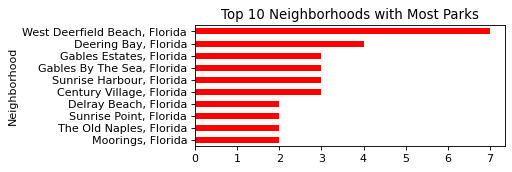

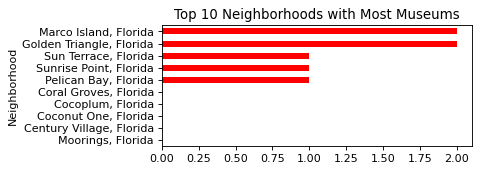

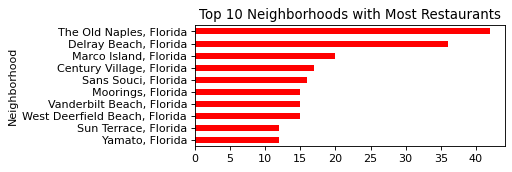

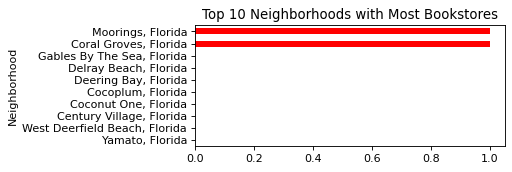

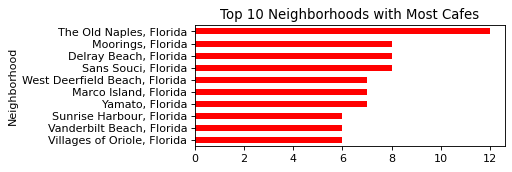

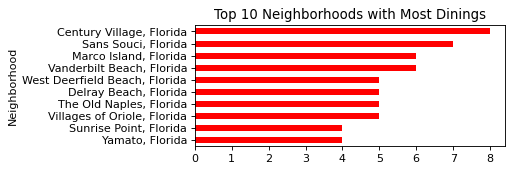

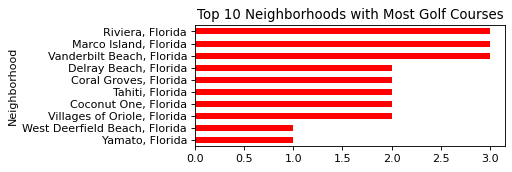

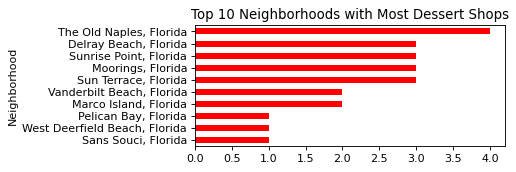

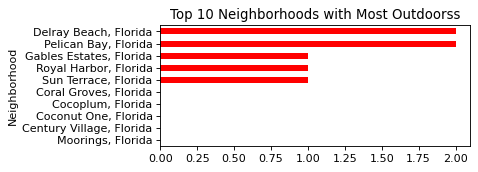

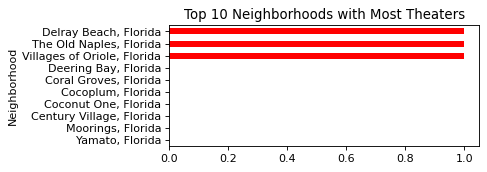

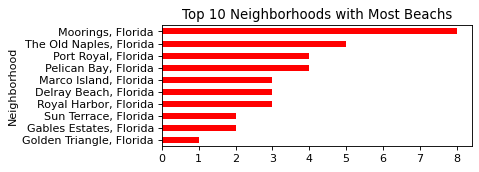

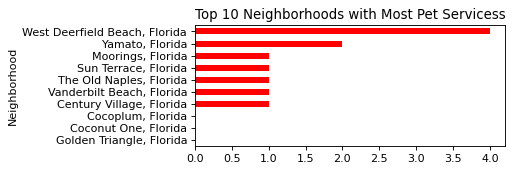

In [81]:
import matplotlib.pyplot as plt
n = 10 #Show top 10 neighbourhoods
clrs = ['red']
for category in cats_of_interest_retire:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'Top {n} Neighborhoods with Most {category}s')
    top_category_neighs = fl_interestv_counts[category].sort_values(ascending=False)[0:n]
    top_category_neighs = top_category_neighs.sort_values(ascending=True)
    top_category_neighs.plot.barh(y=category, rot=0, color=clrs,figsize=(5,2))

#### Determine the total amount of venues of each category 

In [86]:
flvenue_totals = {}
for category in cats_of_interest_retire:
    flvenue_totals[category] = fl_interestv_counts[category].sum()
flvenue_totals


{'Park': 40,
 'Museum': 7,
 'Restaurant': 267,
 'Bookstore': 2,
 'Cafe': 104,
 'Dining': 74,
 'Golf Course': 26,
 'Dessert Shop': 24,
 'Outdoors': 7,
 'Theater': 3,
 'Beach': 36,
 'Pet Services': 11}

#### For each venue category, determine the percentage of entities in each neighborhood

In [85]:
flvenue_mean = pd.DataFrame()
for category, total in flvenue_totals.items():
    flvenue_mean[category] = fl_interestv_counts[category].apply(lambda x: x / total)
flvenue_mean = flvenue_mean.reindex(sorted(flvenue_mean.columns), axis=1).reset_index()
flvenue_mean.head(5)

,Neighborhood,Beach,Bookstore,Cafe,Dessert Shop,Dining,Golf Course,Museum,Outdoors,Park,Pet Services,Restaurant,Theater
0,"Baker Homestead, Florida",0.027778,0.0,0.019231,0.000000,0.027027,0.000000,0.0,0.0,0.025,0.000000,0.041199,0.0
1,"Century Village, Florida",0.000000,0.0,0.048077,0.041667,0.108108,0.000000,0.0,0.0,0.075,0.090909,0.063670,0.0
2,"Coconut One, Florida",0.000000,0.0,0.009615,0.000000,0.000000,0.076923,0.0,0.0,0.000,0.000000,0.007491,0.0
3,"Cocoplum, Florida",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.025,0.000000,0.000000,0.0
4,"Coral Groves, Florida",0.000000,0.5,0.019231,0.000000,0.000000,0.076923,0.0,0.0,0.025,0.000000,0.033708,0.0


#### Creating a dataframe that shows the top 5 venue categories each neighborhood is known for

In [88]:
def return_top_venue_categories(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [105]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Top Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Top Venue Category'.format(ind+1))

neighborhoods_top_venue_categories = pd.DataFrame(columns=columns)
neighborhoods_top_venue_categories['Neighborhood'] = flvenue_mean['Neighborhood']
for ind in np.arange(flvenue_mean.shape[0]):
    neighborhoods_top_venue_categories.iloc[ind, 1:] = return_top_venue_categories(flvenue_mean.iloc[ind, :], num_top_venues)
neighborhoods_top_venue_categories.head(10)

,Neighborhood,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,"Baker Homestead, Florida",Restaurant,Beach,Dining,Park,Cafe
1,"Century Village, Florida",Dining,Pet Services,Park,Restaurant,Cafe
2,"Coconut One, Florida",Golf Course,Cafe,Restaurant,Theater,Pet Services
3,"Cocoplum, Florida",Park,Theater,Restaurant,Pet Services,Outdoors
4,"Coral Groves, Florida",Bookstore,Golf Course,Restaurant,Park,Cafe
5,"Deering Bay, Florida",Park,Golf Course,Theater,Restaurant,Pet Services
6,"Delray Beach, Florida",Theater,Outdoors,Restaurant,Dessert Shop,Beach
7,"Gables By The Sea, Florida",Park,Theater,Restaurant,Pet Services,Outdoors
8,"Gables Estates, Florida",Outdoors,Park,Beach,Restaurant,Theater
9,"Golden Triangle, Florida",Museum,Beach,Dining,Restaurant,Cafe


### Create a KMeans Model To Cluster Neighborhoods

In [106]:
from sklearn.cluster import KMeans
kclusters = 5
venue_grouped_clustering = flvenue_mean.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering) 
neighborhoods_top_venue_categories.insert(1,'Cluster Labels', kmeans.labels_)
neighborhoods_top_venue_categories.head(10)

,Neighborhood,Cluster Labels,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,"Baker Homestead, Florida",1,Restaurant,Beach,Dining,Park,Cafe
1,"Century Village, Florida",1,Dining,Pet Services,Park,Restaurant,Cafe
2,"Coconut One, Florida",1,Golf Course,Cafe,Restaurant,Theater,Pet Services
3,"Cocoplum, Florida",1,Park,Theater,Restaurant,Pet Services,Outdoors
4,"Coral Groves, Florida",0,Bookstore,Golf Course,Restaurant,Park,Cafe
5,"Deering Bay, Florida",1,Park,Golf Course,Theater,Restaurant,Pet Services
6,"Delray Beach, Florida",2,Theater,Outdoors,Restaurant,Dessert Shop,Beach
7,"Gables By The Sea, Florida",1,Park,Theater,Restaurant,Pet Services,Outdoors
8,"Gables Estates, Florida",1,Outdoors,Park,Beach,Restaurant,Theater
9,"Golden Triangle, Florida",3,Museum,Beach,Dining,Restaurant,Cafe


#### Creating a new dataframe merging neighborhood location data, top venue category by neighborhood, and cluster labels

In [130]:
fl_neighborhood_retire_profile = sofl_venues.join(neighborhoods_top_venue_categories.set_index('Neighborhood'), on='Neighborhood').dropna(axis=0)
fl_neighborhood_retire_profile.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,"Marco Island, Florida",25.936336,-81.715683,Mackle Park,25.930477,-81.713267,Park,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining
1,"Marco Island, Florida",25.936336,-81.715683,JW Marriott Marco Island Beach Resort,25.928267,-81.729091,Resort,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining
2,"Marco Island, Florida",25.936336,-81.715683,Marco Island Museum,25.933500,-81.715930,Museum,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining
3,"Marco Island, Florida",25.936336,-81.715683,Tiki Bar,25.928402,-81.729004,Tiki Bar,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining
4,"Marco Island, Florida",25.936336,-81.715683,Marco Beach,25.925858,-81.729895,Beach,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining


In [167]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[26,-81],
    tiles='cartodbpositron',
    zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(fl_neighborhood_retire_profile['Venue Latitude'], fl_neighborhood_retire_profile['Venue Longitude'], fl_neighborhood_retire_profile['Neighborhood'], fl_neighborhood_retire_profile['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### Examining Clusters

In [133]:
fl_neighborhood_retire_profile.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,"Marco Island, Florida",25.936336,-81.715683,Mackle Park,25.930477,-81.713267,Park,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining
1,"Marco Island, Florida",25.936336,-81.715683,JW Marriott Marco Island Beach Resort,25.928267,-81.729091,Resort,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining
2,"Marco Island, Florida",25.936336,-81.715683,Marco Island Museum,25.933500,-81.715930,Museum,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining
3,"Marco Island, Florida",25.936336,-81.715683,Tiki Bar,25.928402,-81.729004,Tiki Bar,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining
4,"Marco Island, Florida",25.936336,-81.715683,Marco Beach,25.925858,-81.729895,Beach,3.0,Museum,Golf Course,Dessert Shop,Beach,Dining


#### Cluster 0

In [150]:
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 0].filter(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile_cl.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
fl_neighborhood_retire_profile_cl


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
382,"Moorings, Florida",26.164257,-81.808144
555,"Coral Groves, Florida",26.498722,-81.965060


In [161]:

fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 0].filter(['Neighborhood','Venue Category'], axis=1)
dftemp = fl_neighborhood_retire_profile_cl.groupby('Neighborhood')['Venue Category'].apply(','.join).reset_index()
dftemp

,Neighborhood,Venue Category
0,"Coral Groves, Florida","Bar,Accessories Store,Sporting Goods Shop,Groc..."
1,"Moorings, Florida","Cafe,Beach,Park,Hotel,Resort,Spa,Beach,Restaur..."


#### Cluster 1

In [151]:
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 1].filter(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile_cl.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
fl_neighborhood_retire_profile_cl


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
99,"Vanderbilt Beach, Florida",26.270642,-81.789809
270,"Port Royal, Florida",26.110926,-81.793144
481,"Royal Harbor, Florida",26.105370,-81.789810
496,"Riviera, Florida",28.509141,-81.286057
536,"Gables By The Sea, Florida",25.650381,-80.276162
542,"Gables Estates, Florida",25.692324,-80.259773
602,"Cocoplum, Florida",25.252879,-80.791675
603,"Baker Homestead, Florida",30.166035,-85.685762
633,"Sunrise Harbour, Florida",29.463452,-98.363218
694,"Deering Bay, Florida",25.638160,-80.290329


In [160]:
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 1].filter(['Neighborhood','Venue Category'], axis=1)
dftemp = fl_neighborhood_retire_profile_cl.groupby('Neighborhood')['Venue Category'].apply(','.join).reset_index()
dftemp

,Neighborhood,Venue Category
0,"Baker Homestead, Florida","Restaurant,Cafe,Restaurant,Restaurant,Restaura..."
1,"Century Village, Florida","Restaurant,Restaurant,Restaurant,Cafe,Dining,H..."
2,"Coconut One, Florida","Hotel,Pool,Restaurant,Hotel,Bar,Cafe,Golf Cour..."
3,"Cocoplum, Florida",Park
4,"Deering Bay, Florida","Golf Course,College Gym,Baseball Field,Boat La..."
5,"Gables By The Sea, Florida","Park,Park,Boat Launch,Park,Baseball Field,Harb..."
6,"Gables Estates, Florida","Park,Pool,Plaza,Beach,Harbor / Marina,Trail,Ou..."
7,"Port Royal, Florida","Housing Development,Beach,Resort,Social Club,B..."
8,"Riviera, Florida","Convenience Store,Cafe,Grocery Store,Discount ..."
9,"Royal Harbor, Florida","Social Club,Beach,Outdoors,Housing Development..."


#### Cluster 2

In [155]:
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 2].filter(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile_cl.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
fl_neighborhood_retire_profile_cl

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
170,"The Old Naples, Florida",26.142198,-81.794294
986,"Villages of Oriole, Florida",26.461677,-80.155213
1120,"Delray Beach, Florida",26.461462,-80.072820


In [159]:

fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 2].filter(['Neighborhood','Venue Category'], axis=1)
dftemp = fl_neighborhood_retire_profile_cl.groupby('Neighborhood')['Venue Category'].apply(','.join).reset_index()
dftemp

,Neighborhood,Venue Category
0,"Delray Beach, Florida","Restaurant,Event Space,Restaurant,Dessert Shop..."
1,"The Old Naples, Florida","Burger Joint,Restaurant,Dessert Shop,Restauran..."
2,"Villages of Oriole, Florida","Restaurant,Golf Course,Gourmet Shop,Restaurant..."


#### Cluster 3

In [156]:
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 3].filter(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile_cl.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
fl_neighborhood_retire_profile_cl

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,"Marco Island, Florida",25.936336,-81.715683
74,"Pelican Bay, Florida",26.232330,-81.810232
282,"Sun Terrace, Florida",24.561579,-81.767012
673,"Golden Triangle, Florida",20.353622,100.081253
735,"Sunrise Point, Florida",28.751030,-81.316192


In [158]:

fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 3].filter(['Neighborhood','Venue Category'], axis=1)
dftemp = fl_neighborhood_retire_profile_cl.groupby('Neighborhood')['Venue Category'].apply(','.join).reset_index()
dftemp

,Neighborhood,Venue Category
0,"Golden Triangle, Florida","Scenic Lookout,Resort,Dining,Resort,Hotel,Muse..."
1,"Marco Island, Florida","Park,Resort,Museum,Tiki Bar,Beach,Restaurant,C..."
2,"Pelican Bay, Florida","Outdoors,Beach,Restaurant,Restaurant,Concert H..."
3,"Sun Terrace, Florida","Creperie,Burger Joint,Dining,Resort,Cafe,Cloth..."
4,"Sunrise Point, Florida","Dining,Restaurant,Dining,Park,Park,Boutique,Ba..."


#### Cluster 4

In [162]:
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 4].filter(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile_cl.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
fl_neighborhood_retire_profile_cl        



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
1034,"West Deerfield Beach, Florida",26.313968,-80.150045


In [163]:
fl_neighborhood_retire_profile_cl = fl_neighborhood_retire_profile.loc[fl_neighborhood_retire_profile['Cluster Labels'] == 4].filter(['Neighborhood','Venue Category'], axis=1)
dftemp = fl_neighborhood_retire_profile_cl.groupby('Neighborhood')['Venue Category'].apply(','.join).reset_index()
dftemp

,Neighborhood,Venue Category
0,"West Deerfield Beach, Florida","Park,Grocery Store,Restaurant,Cafe,Restaurant,..."


#### And here are out top neighborhoods

#### Top 5 Desirable Places:

In [241]:
fl_conclude_ratings=fl_interestv_counts.copy()
fl_conclude_ratings['Venue Total']= fl_conclude_ratings.iloc[:, -20:-1].sum(axis=1) 
fl_conclude_ratings=fl_conclude_ratings.filter(['Neighborhood','Venue Total'], axis=1).sort_values(by=['Venue Total'], ascending=False)
fl_conclude_ratings
dffinal = pd.DataFrame(columns=['venuetotal','neighbourhood_address'])
for index, row in  fl_conclude_ratings.iterrows(): 
    dffinal = dffinal.append({'venuetotal': row['Venue Total'],'neighbourhood_address':index}, ignore_index=True)
dffinal

,venuetotal,neighbourhood_address
0,71,"The Old Naples, Florida"
1,61,"Delray Beach, Florida"
2,44,"Marco Island, Florida"
3,42,"Moorings, Florida"
4,40,"West Deerfield Beach, Florida"
5,35,"Century Village, Florida"
6,33,"Vanderbilt Beach, Florida"
7,33,"Sans Souci, Florida"
8,30,"Sun Terrace, Florida"
9,27,"Yamato, Florida"


In [243]:
dffinalloc = pd.merge(dffinal,df_sfneigh, on='neighbourhood_address')
dffinalloc.head(10)

,venuetotal,neighbourhood_address,county,city,citytype,address,location,point,latitude,longitude,altitude,neighbourhood
0,71,"The Old Naples, Florida",Collier,Naples,city,"Naples, Florida","(Naples, Collier County, Florida, United State...","(26.1421976, -81.7942944, 0.0)",26.142198,-81.794294,0.0,The Old Naples
1,61,"Delray Beach, Florida",Palm Beach,Boca Raton,city,"Boca Raton, Florida","(Delray Beach, Palm Beach County, Florida, Uni...","(26.4614625, -80.0728201, 0.0)",26.461462,-80.072820,0.0,Delray Beach
2,44,"Marco Island, Florida",Collier,Marco Island,city,"Marco Island, Florida","(Marco Island, Collier County, Florida, United...","(25.9363356, -81.7156832, 0.0)",25.936336,-81.715683,0.0,Marco Island
3,42,"Moorings, Florida",Collier,Naples,city,"Naples, Florida","(The Moorings, Naples, Collier County, Florida...","(26.1642572, -81.8081438, 0.0)",26.164257,-81.808144,0.0,Moorings
4,40,"West Deerfield Beach, Florida",Palm Beach,Boca Raton,city,"Boca Raton, Florida","(West Deerfield Beach, Deerfield Beach, Browar...","(26.313968, -80.1500451, 0.0)",26.313968,-80.150045,0.0,West Deerfield Beach
5,35,"Century Village, Florida",Palm Beach,Boca Raton,city,"Boca Raton, Florida","(Century Village, West Palm Beach, Palm Beach ...","(26.71522405, -80.12789844873586, 0.0)",26.715224,-80.127898,0.0,Century Village
6,33,"Vanderbilt Beach, Florida",Collier,Marco Island,city,"Marco Island, Florida","(Vanderbilt Beach, Pelican Marsh, Collier Coun...","(26.2706419, -81.7898093, 0.0)",26.270642,-81.789809,0.0,Vanderbilt Beach
7,33,"Sans Souci, Florida",Miami-Dade,Coral Gables,city,"Coral Gables, Florida","(Sans Souci, Jacksonville, Duval County, Flori...","(30.2812249, -81.5919478, 0.0)",30.281225,-81.591948,0.0,Sans Souci
8,30,"Sun Terrace, Florida",Collier,Naples,city,"Naples, Florida","(Sun Terrace, Key West, Monroe County, Florida...","(24.5615788, -81.7670124, 0.0)",24.561579,-81.767012,0.0,Sun Terrace
9,27,"Yamato, Florida",Palm Beach,Boca Raton,city,"Boca Raton, Florida","(Yamato, Boca Raton, Palm Beach County, Florid...","(26.4094491, -80.0895362, 0.0)",26.409449,-80.089536,0.0,Yamato


In [249]:
maptopplaces = folium.Map(
    location=[26,-81],
    tiles='cartodbpositron',
    zoom_start=8,
)
dffinalloc=dffinalloc.head(10)
dffinalloc.apply(lambda row:folium.CircleMarker(
    location=[row["latitude"], 
              row["longitude"]],radius=row["venuetotal"]/10,color='blue',
    fill=True,fill_color='blue',
    fill_opacity=0.8).add_to(maptopplaces), axis=1)
dffinalloc.apply(lambda row:folium.Marker(
    location=[row["latitude"], 
              row["longitude"]],
        icon=DivIcon( html='<div style="font-size: 8pt">'+row["neighbourhood"]+'</div>')
        ).add_to(maptopplaces), axis=1)
    
maptopplaces